# 爬蟲_博客來暢銷排行榜

## 程式碼解說影片連結：https://youtu.be/0jCilIHBKaA
### 用線上剪輯軟體編輯後，影片音量變得有點不一致，如觀看上有問題再請聯絡我，感謝！

## 1. 程式碼模組化

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import json
# import time

In [2]:
class BookTopSalesCrawler:
    def __init__(self):
        self.BASE_URL = 'https://www.books.com.tw/web/sys_saletopb/'
        self.session = requests.Session()
        self.catagory = {'中文':'books','簡體':'china','外文':'fbooks'} #排行榜語言類參數對照
        self.days = {'7':'7', '30':'30'} #排行榜天數參數對照
        self.data = [] #儲存書籍資訊
        
    
    #抓取書籍內容簡介
    def fetch_content(self,page):
        response = self.session.get(page)
        
        if response.status_code not in [200,484]: #484應該是博客來的自定義代號
            print(f"{str(response.status_code)} 無法訪問書籍頁面 {page}")
            return ''
        
        soup = BeautifulSoup(response.text, 'html.parser')
    
        #有的書籍有閱讀年齡的限制，必須登入會員才可以觀看，因此這類書籍的內容簡介無法抓取，故使用空值替代
        try:
            text = soup.select_one('div.content').text
            cleaned_text = re.sub(r'[\n\u3000\xa0]+', '', text).strip() #使用正則化
            return cleaned_text
        
        except AttributeError:
            return ''


    #抓取排行榜頁面的書名、作者、售價、書籍頁面連結
    def fetch_pages(self, language, duration): #可根據輸入的語言類別與天數抓取指定頁面
        current_page = f'{self.BASE_URL}{self.catagory[language]}/?attribute={self.days[duration]}'
        response = self.session.get(current_page)
        
        if response.status_code != 200:
            print(f"無法訪問排行榜頁面 {current_page}")
            return None
        
        soup = BeautifulSoup(response.text, 'html.parser')
        
        for channel in soup.select('div.type02_bd-a'): #選取所有 class 為 type02_bd-a 的 div 元素
            
            #選取第一個 href 屬性含有 products 字串的 a 標籤，href 屬性值
            link = channel.select_one("a[href*=products]")['href']
            
            #選取 h4 標籤下 a 標籤的文字內容
            title = channel.select_one("h4 > a").text
            
            #選取 class 為 msg 的 ul 標籤下第一個 li 元素的文字內容，並使用正則化清理資料
            if "作者" in channel.select_one("ul.msg > li:nth-child(1)").text:
                author_text = channel.select_one("ul.msg > li:nth-child(1)").text
                author = re.sub(r'作者：?', '', author_text)
            #有些書籍沒有顯示作者，故給空值
            else:
                author = ''
            
            #選取 class 為 msg 的 ul 標籤下，class 為 price_a 的 li 元素的文字內容，並使用正則化清理資料
            price_text = channel.select_one("ul.msg > li.price_a").text
            price_match = re.search(r'(\d+)元', price_text)
            if price_match:
                price = int(price_match.group(1))
            else:
                price = None

            content = self.fetch_content(link) #呼叫抓取書籍內容簡介的Function，並產製書本簡介內容
            self.data.append({'title': title, 'author': author, 'price': price, 'link': link, 'intro': content})
            
#             sleep.time(1)
    
    
    #把資料變成dataframe
    def to_dataframe(self):
        return pd.DataFrame(self.data)

## 2. 使用模組內的function爬取中文書近30天銷售排行榜的資料
### 排行榜語言：中文、簡體、外文
### 近X日暢銷榜：7、30

In [3]:
crawler = BookTopSalesCrawler()
crawler.fetch_pages('中文','30') #輸入要抓取的語言種類與天數
df = crawler.to_dataframe()
df

,title,author,price,link,intro
0,巨人思維：沒有捷徑，只有努力，從零開始的股市交易員,巨人傑,355,https://www.books.com.tw/products/0010985179?l...,★本書所有版稅收入捐贈給財團法人台灣兒童暨家庭扶助基金會★ ★巨人傑首度出書！萬千散戶引頸企...
1,排球少年！！10週年編年史 全 (首刷限定版),古舘春一,629,https://www.books.com.tw/products/0010984894?l...,本書有歷任責編與老師多達90頁的長篇對談，《排球少年！！》從2012年連載至今的大小企劃、週...
2,消失的愛：逆轉我們的時代（博客來獨家印簽版）,陳文茜,379,https://www.books.com.tw/products/0010984248?l...,這是我二○一九年病倒後，發願寫作的五本書籍中，最重要的書籍。當時的我已休克三次，身上裝了人工...
3,仙靈傳奇之古物奇探：祝由師上下冊套書（首刷加贈新系列雙面海報+上冊作者印簽金句扉頁）,陳郁如,570,https://www.books.com.tw/products/0010984640?l...,系列熱銷50萬冊、華文奇幻必讀經典【仙靈傳奇】全新系列年度暢銷作家陳郁如Ｘ國立故宮博物院首次...
4,便當實驗室開張：每天做給老公、女兒，偶爾也自己吃,高木直子,276,https://www.books.com.tw/products/0010985448?l...,啊，該起來了……今天也要接受挑戰！菜色變化好有趣~~記得小時候帶便當的經驗嗎？是不是每天都很...
...,...,...,...,...,...
95,全新！新制多益 TOEIC 閱讀題庫解析 ：全新收錄精準 10 回模擬試題！每月進場實測分析...,Hackers Academia,695,https://www.books.com.tw/products/0010881804?l...,最接近實際多益測驗的仿真模擬試題！全新收錄完整 10 回閱讀測驗緊扣出題核心、精準模擬實際測...
96,孩子的不凡，來自你的不厭其煩：神老師的陪伴全教養，讓每個孩子的價值都能被看見,神老師&神媽咪（沈雅琪）,276,https://www.books.com.tw/products/0010982370?l...,沒有任何一個孩子應該被放棄──陪伴，是你所能給孩子們最美的奇蹟！台灣教育界最受家長信賴的教師...
97,我內心的糟糕念頭 6,桜井紀雄,105,https://www.books.com.tw/products/0010983360?l...,２月１４日…情人節。原本這應該是－－－與陰沉者．京太郎沒有關係的日子，但山田的狀況卻顯得比平...
98,你想活出怎樣的人生？【品格形塑經典，宮崎駿為它復出，親自改編電影】,吉野源三郎,229,https://www.books.com.tw/products/0010799268?l...,宮崎駿為它復出，親自改編電影 撫慰騷動不安的靈魂，找到人生方向的最佳著作無論世界變得如何混亂...


## 3. 將Dataframe儲存成CSV；轉成字典後儲存成JSON

In [4]:
# 將資料寫入csv文件
df.to_csv('BookTopSales30Days.csv', index=False, encoding='utf-8-sig')

In [5]:
#把資料變成字典，並取出第一項資料查看
records = df.to_dict('records')
records[0]

{'title': '巨人思維：沒有捷徑，只有努力，從零開始的股市交易員',
 'author': '巨人傑',
 'price': 355,
 'link': 'https://www.books.com.tw/products/0010985179?loc=P_0003_001',
 'intro': '★本書所有版稅收入捐贈給財團法人台灣兒童暨家庭扶助基金會★ ★巨人傑首度出書！萬千散戶引頸企盼，2024就等這一冊！★ ★台股傳奇交易員，14年的交易思路紀實★ 他17歲入股市，從懵懂的股市小白開始， 直到成為舉市皆聞的重磅級散戶！ 秉著熾熱的「交易魂」，他不惜犧牲娛樂與睡眠的時間， 反覆研究市場與規則，用真金白銀持續交易， 台股、海期、選擇權，每個市場都有他留下的痕跡…… 台灣散戶最好奇的神祕交易員巨人傑，首度公開投資思維！「這本書，並不是坊間的致富寶典、絕世武功，也沒有神奇的絕技。這本書，看完之後不會讓你從此發大財、財富自由，不再需要工作。這本書，我希望你看完之後，會放棄靠價差交易致富，因為那真的很不容易。」──巨人傑在驚滔駭浪般的人生戰績背後，隱藏的卻只是最平凡無奇的過程與方法。巨人傑用最平淡的語氣，娓娓道來他從17歲開始，一路上的思考與領悟。儘管他的名號在台灣股市（尤其是年輕股票族群）當中已經極為響亮，他也已經成為眾多股民嚮往與學習的對象，但他對自己的成功，卻只是謙虛地如此表示：「如果有一個人，每天都在市場交易加研究十七小時以上，並且持續十年，這種人在股市賺不到錢的機會趨近於零。」並非交易天才的他，從高中才開始對數字產生興趣，初次接觸股市，便對數字的跳動深深感到著迷的他，就這樣一頭栽進了股海之中。他沒有萬貫家財撐腰，也沒有傳奇名師指導，起始本金更是只有一萬，這樣的他，究竟如何從少少的本金開始，成為生涯累計成交量破五千億的億級散戶？◎交易員的起始之路：不要想尋找必勝的技巧巨人傑：「不是只要等指標轉強買進，抱著就可以吃一大段嗎？為什麼會這樣被洗呢？而且為什麼我用了更多指標之後，卻好像變成更抱不住了？理論上，只要等突破均線買進，抱著均線就可以賺一○○％，那這些所謂輕鬆賺的錢呢？為什麼沒有出現在我的對帳單上？於是乎，我終於知道，股市賺錢沒那麼簡單。」初入股市時，巨人傑也曾經以為，只要成為技術分析王，就能制霸市場。如果那些技術分析大師們都各自有擅長的指標，那麼只要

In [6]:
# 將字典寫入JSON文件
with open('BookTopSales30Days_json', 'w', encoding='utf-8') as f:    
    json.dump(records, f, ensure_ascii=False, indent=4)

## 4. 提取關鍵字、繪製關聯圖

In [7]:
import jieba
import jieba.analyse

In [8]:
def extract_keywords(text):
    return jieba.analyse.extract_tags(text, topK=10) #提取前十個關鍵字

#創建一個新欄位keywords存放intro資料使用extract_keywords這個functionc後的結果
df['keywords'] = df['intro'].apply(extract_keywords)
df.head(10)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/4p/wgl8n9h55p3g6ld2z3r4jn5m0000gn/T/jieba.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


,title,author,price,link,intro,keywords
0,巨人思維：沒有捷徑，只有努力，從零開始的股市交易員,巨人傑,355,https://www.books.com.tw/products/0010985179?l...,★本書所有版稅收入捐贈給財團法人台灣兒童暨家庭扶助基金會★ ★巨人傑首度出書！萬千散戶引頸企...,"[交易, 市場, 巨人, 開始, 賠錢, 股市, 持續, 機會, 那麼, 策略]"
1,排球少年！！10週年編年史 全 (首刷限定版),古舘春一,629,https://www.books.com.tw/products/0010984894?l...,本書有歷任責編與老師多達90頁的長篇對談，《排球少年！！》從2012年連載至今的大小企劃、週...,"[排球, 少年, 本書有, 歷任, 責編, 老師, 90, 2012, 連載, 企劃]"
2,消失的愛：逆轉我們的時代（博客來獨家印簽版）,陳文茜,379,https://www.books.com.tw/products/0010984248?l...,這是我二○一九年病倒後，發願寫作的五本書籍中，最重要的書籍。當時的我已休克三次，身上裝了人工...,"[我們, 全球化, 時代, 歷史, 這個, 美國, 書籍, 什麼, 一個, 中國]"
3,仙靈傳奇之古物奇探：祝由師上下冊套書（首刷加贈新系列雙面海報+上冊作者印簽金句扉頁）,陳郁如,570,https://www.books.com.tw/products/0010984640?l...,系列熱銷50萬冊、華文奇幻必讀經典【仙靈傳奇】全新系列年度暢銷作家陳郁如Ｘ國立故宮博物院首次...,"[仙靈, 傳奇, 故宮, 郁如, 閱讀, 國立, 奇幻, 故事, 冒險, 讀者]"
4,便當實驗室開張：每天做給老公、女兒，偶爾也自己吃,高木直子,276,https://www.books.com.tw/products/0010985448?l...,啊，該起來了……今天也要接受挑戰！菜色變化好有趣~~記得小時候帶便當的經驗嗎？是不是每天都很...,"[便當, 高木, 女兒, 菜色, 一天, 小米, 時候, 時間, 準備, 時刻]"
5,三體系列燙銀簽名套書,劉慈欣,1012,https://www.books.com.tw/products/0010950997?l...,歐巴馬、《冰與火之歌》作者強力推薦！想像奇詭，氣勢磅礴，寄托深遠，堪稱百年中文科幻小説的首選...,"[三體, 科幻, 宇宙, 地球, 文明, 兩個, 執劍人, 面壁, 人類, 中國]"
6,我可能錯了：森林智者的最後一堂人生課,"比約恩．納提科．林德布勞,卡洛琳．班克勒,納維德．莫迪里",355,https://www.books.com.tw/products/0010947051?l...,達賴喇嘛：這本書能使所有人受益瑞典最暢銷心靈書，連續三年獲獎不斷！隱居山林的經濟學家，最動人...,"[這本書, 讀者, 一本, 比約, 喜歡, 智慧, 瑞典, 這是, 充滿, 我們]"
7,抄寫英語的奇蹟：1天10分鐘，英語和人生都起飛,林熙 Brett Lindsay,300,https://www.books.com.tw/products/0010982908?l...,外籍名師親自編寫，最道地的正能量英語！涵蓋人生最重要的10大主題，每10天輪動一次，不僅勵志...,"[階段, 10, 母語, 英語, 改變, 100, 學習, 人生, 英文, 分鐘]"
8,原子習慣：細微改變帶來巨大成就的實證法則,詹姆斯‧克利爾,260,https://www.books.com.tw/products/0010822522?l...,每天都進步1%，一年後，你會進步37倍；每天都退步1%，一年後，你會弱化到趨近於0！你的一點...,"[習慣, 改變, 養成, 推薦, 本書, 作家, 進步, 商業, 戒除, 知名]"
9,艾蜜莉存股術2.0：月薪2.5萬起步 滾到5千萬財富,艾蜜莉,331,https://www.books.com.tw/products/0010983891?l...,艾蜜莉，台灣股市最具代表性的「小資女」， 從50萬元始起步，6年賺到400萬、10年累積75...,"[投資, 艾蜜莉, 價值, 財富, 存股, 薪水, 累積, 20, 100%, 開始]"


In [9]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from community import community_louvain

In [10]:
#選取排行榜前25名製作關聯圖，使用作者當作母節點、關鍵字擔任子節點
G = nx.Graph()

for index, row in df.head(25).iterrows():
    author = row['author']
    keywords = row['keywords']

    G.add_node(author, type='author')

    for keyword in keywords:
        G.add_node(keyword, type='keyword')
        G.add_edge(author, keyword)

In [11]:
#使用justfont的粉圓字
import matplotlib as mpl
from matplotlib.font_manager import fontManager

fontManager.addfont('jf-openhuninn-2.0.ttf')
mpl.rc('font', family='jf-openhuninn-2.0')

/usr/local/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


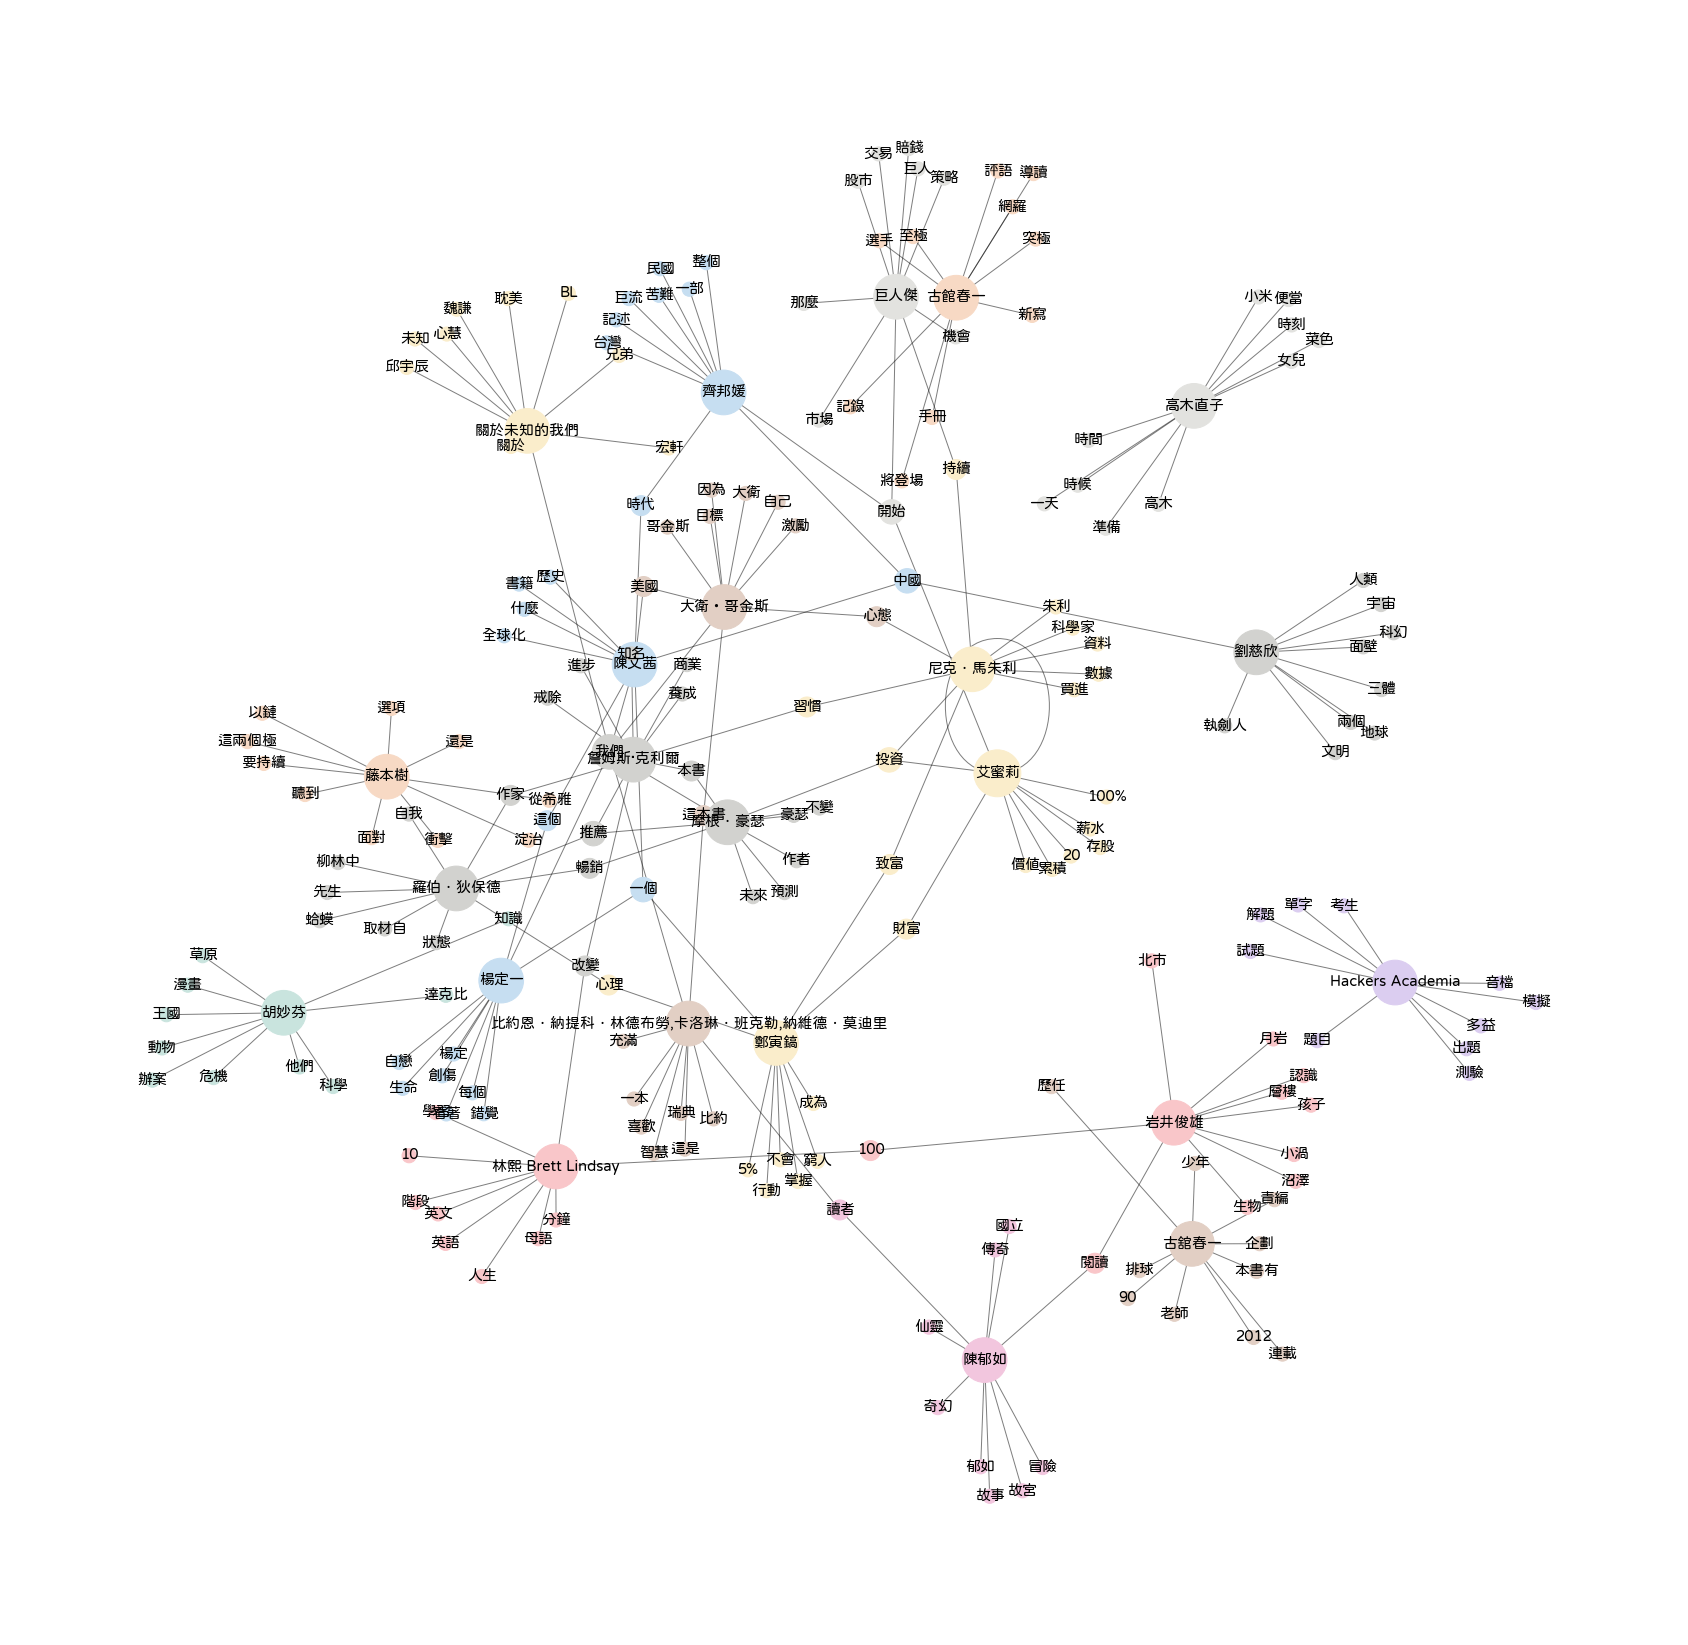

In [12]:
#繪製關聯圖，並使用指定的10種顏色
partition = community_louvain.best_partition(G)

community_colors = [partition[node] for node in G.nodes()]

cmap = plt.cm.jet

custom_colors = ["#e2e2df","#d2d2cf","#e2cfc4","#f7d9c4","#faedcb","#c9e4de","#c6def1","#dbcdf0","#f2c6de","#f9c6c9"]
colors_with_alpha = [custom_colors[community_color % len(custom_colors)] for community_color in community_colors]

node_sizes = [200 * G.degree(node) for node in G.nodes()]

pos = nx.spring_layout(G, k=0.25, iterations=85, scale=2)

plt.figure(figsize=(30, 30))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_color=colors_with_alpha, node_size=node_sizes, cmap=plt.cm.jet)
nx.draw_networkx_labels(G, pos, font_size=15, font_family='jf-openhuninn-2.0')

plt.axis('off')
plt.show()